In [1]:
# -------------------------------------------------------------------------------------------------
# LOAD REQUIRED LIBRARIES
# -------------------------------------------------------------------------------------------------
%matplotlib inline
import netCDF4
from distutils.util import strtobool
import pylab
import matplotlib
import matplotlib.pyplot as plt
import sys
import os
import platform
import numpy as np
import pyproj as pyproj
import datetime
import pdb
import time
import bmi.wrapper
import pcrglobwb_203_30min_2way as pcrglobwb_bmi_v203
from pcrglobwb_203_30min_2way import pcrglobwb_bmi
from pcrglobwb_203_30min_2way import disclaimer
from coupling_PCR_FM_2way import coupling_functions
from coupling_PCR_FM_2way import model_functions
from coupling_PCR_FM_2way import configuration

/home/jannis/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# -------------------------------------------------------------------------------------------------
# IMPORT MODEL SETTINGS FROM INI-FILE/SET-FILE
# -------------------------------------------------------------------------------------------------

arg = r'/home/jannis/PhD/scripts/2WAY/2way_AMA_1d2d_codeDevelopment.ini'

config = configuration.Configuration()
#config.parse_configuration_file(sys.argv[1])
config.parse_configuration_file(arg)

In [3]:
# -------------------------------------------------------------------------------------------------
# SPECIFY MODEL SETTINGS
# -------------------------------------------------------------------------------------------------

model_type = config.model_type['model_type']

use_2way = strtobool(config.general_settings['2way coupling'])

latlon = strtobool(config.general_settings['latlon'])
if latlon == False:
	inProj  = pyproj.Proj(init=config.model_settings['model_projection'])

use_Fluxes = strtobool(config.general_settings['use_Fluxes'])

use_RFS = strtobool(config.general_settings['use_RFS'])
if use_2way == True:
	use_RFS = True

verbose = strtobool(config.general_settings['verbose'])

In [4]:
# -------------------------------------------------------------------------------------------------
# SPECIFY NUMERICAL SETTINGS
# -------------------------------------------------------------------------------------------------

nr_model_timesteps                    = int(config.numerical_settings['number_of_timesteps'])
update_step                           = int(config.numerical_settings['update_step'])

secPerDay                             = 86400.
end_time 							  = nr_model_timesteps * secPerDay
fraction_timestep 					  = secPerDay / update_step

threshold_inundated_depth             = float(config.numerical_settings['threshold_inundated_depth'])

# other
missing_value_landmask                = 255
missing_value_pcr                     = -999

In [5]:
# -------------------------------------------------------------------------------------------------
# SET PATHS TO MODELS
# -------------------------------------------------------------------------------------------------

# hydrodynamics
model_dir       	= config.model_settings['model_dir']
model_file      	= config.model_settings['model_file']
model_proj			= config.model_settings['model_projection']

# hydrology
config_pcr       	=  config.PCR_settings['config_pcr']
configPCR           = configuration.Configuration()
configPCR.parse_configuration_file(config_pcr )
inputDIR 			= configPCR.globalOptions['inputDir']
clone_pcr 			= os.path.join(inputDIR, configPCR.globalOptions['cloneMap'])
landmask_pcr 		= os.path.join(inputDIR, configPCR.globalOptions['landmask'])

In [6]:
# -------------------------------------------------------------------------------------------------
# SET PATHS TO .SO / .DLL FILES
# -------------------------------------------------------------------------------------------------

# these may be changed according to personal file and folder structure
if model_type == 'DFM':
    model_path = '/home/jannis/Programmes/DFLOWFM/lib/libdflowfm.so'

elif model_type == 'LFP':
    model_path = '/home/jannis/Programmes/LISFLOODFP/lisflood-bmi-v5.9/liblisflood.so'

else:
    sys.exit('\nno adequate model defined in configuration file - define either DFM or LFP!\n')

In [7]:
# -------------------------------------------------------------------------------------------------
# INITIALIZE AND SPIN-UP PCR-GLOBWB
# -------------------------------------------------------------------------------------------------

# initiate logging and define folder for verbose-output
verbose_folder = model_functions.write2log(model_dir, model_file, latlon, use_2way, use_Fluxes, use_RFS, use_floodplain_infiltration_factor=False, adjust_initial_groundwater=False, verbose=False, moment='start')
print 'Model Start-Time: ', datetime.datetime.now()
print ''

# initiate PCR-GLOBWB
hydrologicModel = pcrglobwb_bmi_v203.pcrglobwb_bmi.pcrglobwbBMI()
hydrologicModel.initialize(config_pcr)
print '\n>>> PCR Initialized <<<\n'

# spin-up PCR-GLOBWB
hydrologicModel.spinup()

2018-02-12 12:33:21,794 pcrglobwb_203_30min_2way.configuration INFO Model run started at 2018-02-12 12:33:21.789464
2018-02-12 12:33:21,794 pcrglobwb_203_30min_2way.configuration INFO Logging output to /home/jannis/PhD/data_PCR/output/2way/AMA/1d2d_DFM_codeDevelopment/log/AMA_2way_30min_kinWave_2.5km.ini_2018-02-12T12:33:21.789464.log
2018-02-12 12:33:21,795 pcrglobwb_203_30min_2way.configuration INFO Note that avgSurfaceWaterInputLongIni is not used and not needed.
2018-02-12 12:33:21,796 pcrglobwb_203_30min_2way.currTimeStep INFO number of time steps :2557



##############################
### MODEL COUPLING STARTED ###
##############################

model file chosen:  AMA_DFM_2km_1D2D.mdu
2way coupling activated:  True
lat-lon on:  True
fluxes on:  True
RFS on:  True
use floodplain infiltration factor:  False
adjust initial groundwater:  False
verbose mode on:  False

Model Start-Time:  2018-02-12 12:33:21.789183



2018-02-12 12:33:22,101 pcrglobwb_203_30min_2way.meteo INFO No forcing downscaling is implemented.
2018-02-12 12:33:26,564 pcrglobwb_203_30min_2way.waterBodies INFO WARNING!! Using only natural water bodies identified in the year 1900. All reservoirs in 1900 are assumed as lakes.
2018-02-12 12:33:27,697 pcrglobwb_203_30min_2way.deterministic_runner INFO Adjusting some model parameters based on given values in the ini/configuration file.
2018-02-12 12:33:27,698 pcrglobwb_203_30min_2way.deterministic_runner INFO 

Multiplier values used: 
For minSoilDepthFrac           : 0.5
For kSat (log-scale)           : 0.5
For recessionCoeff (log-scale) : 0.5
For storCap                    : 1.0
For degreeDayFactor            : 1.0
For refPotET                   : 1.0

2018-02-12 12:33:27,702 pcrglobwb_203_30min_2way.pcrglobwb_bmi INFO Model initialized. Spin-up might be required.
2018-02-12 12:33:27,703 pcrglobwb_203_30min_2way.pcrglobwb_bmi INFO Spin-Up #Total Years: 1
2018-02-12 12:33:27,703 pcrg


>>> PCR Initialized <<<



2018-02-12 12:33:28,033 pcrglobwb_203_30min_2way.meteo INFO No forcing downscaling is implemented.
2018-02-12 12:33:32,520 pcrglobwb_203_30min_2way.waterBodies INFO WARNING!! Using only natural water bodies identified in the year 1900. All reservoirs in 1900 are assumed as lakes.
2018-02-12 12:33:33,672 pcrglobwb_203_30min_2way.deterministic_runner INFO Adjusting some model parameters based on given values in the ini/configuration file.
2018-02-12 12:33:33,673 pcrglobwb_203_30min_2way.deterministic_runner INFO 

Multiplier values used: 
For minSoilDepthFrac           : 0.5
For kSat (log-scale)           : 0.5
For recessionCoeff (log-scale) : 0.5
For storCap                    : 1.0
For degreeDayFactor            : 1.0
For refPotET                   : 1.0

2018-02-12 12:33:33,676 pcrglobwb_203_30min_2way.currTimeStep INFO Spin-Up 1 of 1
2018-02-12 12:33:33,677 pcrglobwb_203_30min_2way.pcrglobwb INFO reading forcings for time 1984-01-01
2018-02-12 12:33:33,839 pcrglobwb_203_30min_2way.pc

In [8]:
# -------------------------------------------------------------------------------------------------
# INITIALIZING HYDRODYNAMIC MODEL
# -------------------------------------------------------------------------------------------------

# initiate hydraulic model
hydrodynamicModel = bmi.wrapper.BMIWrapper(engine = model_path, configfile = (os.path.join(model_dir, model_file)))
hydrodynamicModel.initialize()
print '\n>>> ',model_type,' Initialized <<<\n'

2018-02-12 12:38:57,855 bmi.wrapper INFO Loading library from path /home/jannis/Programmes/DFLOWFM/lib/libdflowfm.so
2018-02-12 12:38:57,869 bmi.wrapper INFO Loading model /home/jannis/Desktop/PhD/data_FM/2way/AMA/1D2D/DFM_AMA_1D2D_2.5KM/AMA_DFM_2km_1D2D.mdu in directory /home/jannis/PhD/data_FM/2way/AMA/1D2D/DFM_AMA_1D2D_2.5KM



>>>  DFM  Initialized <<<



In [9]:
# -------------------------------------------------------------------------------------------------
# EXCTRACTING RELEVANT DATA FROM MODELS
# -------------------------------------------------------------------------------------------------
#

if model_type == 'DFM':

    #- retrieving data from Delft3D FM
    bottom_lvl, cell_points_fm, separator_1D, cellAreaSpherical_1D, cellAreaSpherical_2D, xz_coords, yz_coords, \
					hydrodynamic_coords_1D, hydrodynamic_coords_2D = model_functions.extractModelData_DFM(hydrodynamicModel, use_RFS, use_2way)

    coupledFPindices = 0.
    print '\n>>> DFM data retrieved <<<\n'

elif model_type == 'LFP':

    #- retrieving data from LISFLOOD-FP
    dx, dy, DEM, bottom_lvl, H, waterDepth, rows, cols, \
                list_x_coords, list_x_coords_2way, list_y_coords, list_y_coords_2way, coupledFPindices, coupledFPindices_2way, grid_dA, cellAreaSpherical_1D, \
				SGCQin, separator_1D, = model_functions.extractModelData_LFP(hydrodynamicModel, model_dir, verbose_folder, use_RFS, use_2way, verbose)

    cellAreaSpherical_2D = np.copy(cellAreaSpherical_1D)

    #- computing FP-coordinates
    hydrodynamic_coords_1D = coupling_functions.getVerticesFromMidPoints(list_x_coords, list_y_coords, dx, dy, verbose)
    hydrodynamic_coords_2D = coupling_functions.getVerticesFromMidPoints(list_x_coords_2way, list_y_coords_2way, dx, dy, verbose)
    print '\n>>> LFP data retrieved <<<\n'

#- computing PCR-coordinates
cellarea_data_pcr, landmask_data_pcr, clone_data_pcr = model_functions.extractModelData_PCR(hydrologicModel, landmask_pcr, clone_pcr)
PCRcoords = coupling_functions.getPCRcoords(landmask_data_pcr)
print '\n>>> PCR data retrieved <<<\n'


>>> DFM data retrieved <<<


>>> PCR data retrieved <<<



In [10]:
# -------------------------------------------------------------------------------------------------
# ACTIVATING COUPLING FOR RELEVANT PCR SECTIONS
# -------------------------------------------------------------------------------------------------

hydrologicModel.set_var(('grassland','ActivateCoupling'), 'True') #2way
hydrologicModel.set_var(('forest','ActivateCoupling'), 'True') #2way
hydrologicModel.set_var(('routing','ActivateCoupling'), 'True')
hydrologicModel.set_var(('WaterBodies', 'ActivateCoupling'), 'True')

In [11]:
# -------------------------------------------------------------------------------------------------
# COUPLING THE GRIDS
# -------------------------------------------------------------------------------------------------

# converting single indices of coupled PCR cells to double (array,column) indices
# couple_HDYN_2_HLOG: list containing indices of all coupled hydrodynamic cells with their corresponding index of coupled hydrologic cell (one-to-one)
# couple_HLOG_2_HDYN: list containing indices of all coupled hydrologic cells with their corresponding indices of coupled hydrodynamic cells (one-to-many_
# coupled_HLOG_indices: list containing indices of all coupled PCR cells

if use_2way == False:
	# linking PCR-cells with 1D hydrodynamic cells (if use_RFS=True) or 2D hydrodynamic cells (if use_RFS=False)
    couple_HDYN_2_HLOG, couple_HLOG_2_HDYN, coupled_HLOG_indices = coupling_functions.assignPCR2cells(landmask_pcr, hydrodynamic_coords_1D, verbose)

elif use_2way == True:
	# linking PCR-cells with 1D hydrodynamic cells (since use_RFS=True)
    couple_HDYN_2_HLOG, couple_HLOG_2_HDYN, coupled_HLOG_indices = coupling_functions.assignPCR2cells(landmask_pcr, hydrodynamic_coords_1D, verbose)
	# linking PCR-cells with 2D hydrodynamic cells
    couple_HDYN_2_HLOG_2way, couple_HLOG_2_HDYN_2way, coupled_HLOG_indices_2way = coupling_functions.assignPCR2cells(landmask_pcr, hydrodynamic_coords_2D, verbose)


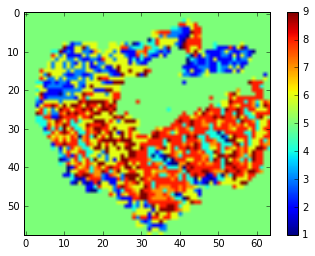

In [12]:
# -------------------------------------------------------------------------------------------------
# TURNING OFF ROUTING BY PCR IN COUPLED AREA
#
# for 1D <-> PCR
# this is required to avoid double-routing by HDYN and HLOG (as we want to perform the routing by HDYN only!)
# -------------------------------------------------------------------------------------------------

model_functions.noLDD(hydrologicModel, coupled_HLOG_indices, verbose_folder, verbose)

plt.figure()
plt.imshow(hydrologicModel.get_var(('routing', 'lddMap')))
plt.colorbar()
plt.savefig(os.path.join(verbose_folder,'coupledLDD.png'), dpi=300)

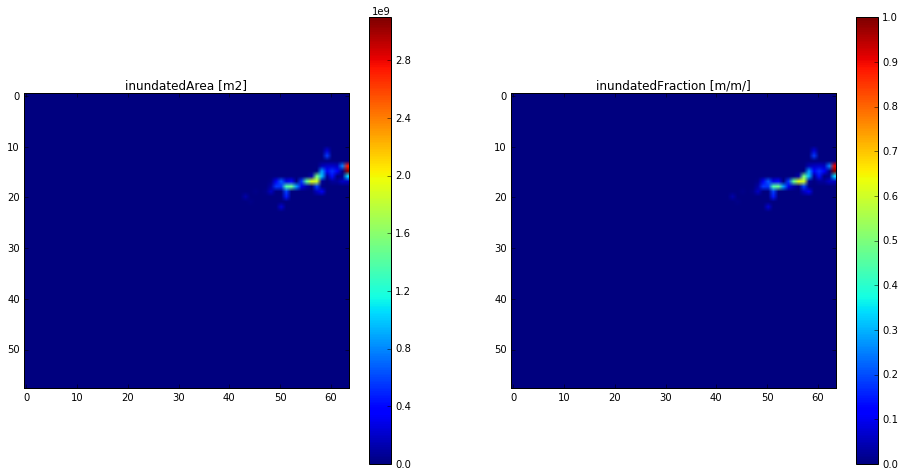

In [13]:
# -------------------------------------------------------------------------------------------------
# COMPUTING INUNDATION AS AREA AND AS FRACTION OF PCR-CELL
#
# inundatedArea_HDYN1D_2_HLOG			= list with upscaled inundated area of all 1D hydrodynamic cells within a hydrologic cell
# inundatedArea_HDYN2D_2_HLOG			= list with upscaled inundated area of all 2D hydrodynamic cells within a hydrologic cell
# inundatedArea_HDYN2D_2_HLOG_BMI		= array of upscaled inundated area of all 2D hydrodynamic cells within a hydrologic cell; to be used with BMI-command
# inundatedFraction_HDYN2D_2_HLOG		= list with fractional inundated area of all 2D hydrodynamic cells per hydrologic cell
# inundatedFraction_HDYN2D_2_HLOG_BMI	= array of fractional inundated area of all 2D hydrodynamic cells per hydrologic cell; to be used with BMI-command
# -------------------------------------------------------------------------------------------------

inundatedArea_HDYN1D_2_HLOG, inundatedArea_HDYN2D_2_HLOG, inundatedArea_HDYN2D_2_HLOG_BMI, \
			inundatedFraction_HDYN2D_2_HLOG, inundatedFraction_HDYN2D_2_HLOG_BMI = model_functions.determine_InundationArea_Hydrodynamics(model_type,
                                                                                                                                        hydrodynamicModel,
                                                                                                                                        couple_HLOG_2_HDYN,
                                                                                                                                        coupled_HLOG_indices,
																																		couple_HLOG_2_HDYN_2way,
																																		coupled_HLOG_indices_2way,
																																		threshold_inundated_depth,
																																		cellAreaSpherical_1D,
																																		cellAreaSpherical_2D,
																																		cellarea_data_pcr,
																																		landmask_pcr,
																																		missing_value_landmask)
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.title('inundatedArea [m2]')
plt.imshow(inundatedArea_HDYN2D_2_HLOG_BMI)
plt.colorbar()
#plt.savefig(os.path.join(verbose_folder,'inundatedArea_HDYN2D_2_HLOG_BMI.png'), dpi=300)
plt.subplot(122)
plt.title('inundatedFraction [m/m/]')
plt.imshow(inundatedFraction_HDYN2D_2_HLOG_BMI, vmin=0, vmax=1)
plt.colorbar()
plt.savefig(os.path.join(verbose_folder,'inundatedAreaAndFraction_HDYN2D_2_HLOG_BMI.png'), dpi=300)

-603472394.802 3901294103.34


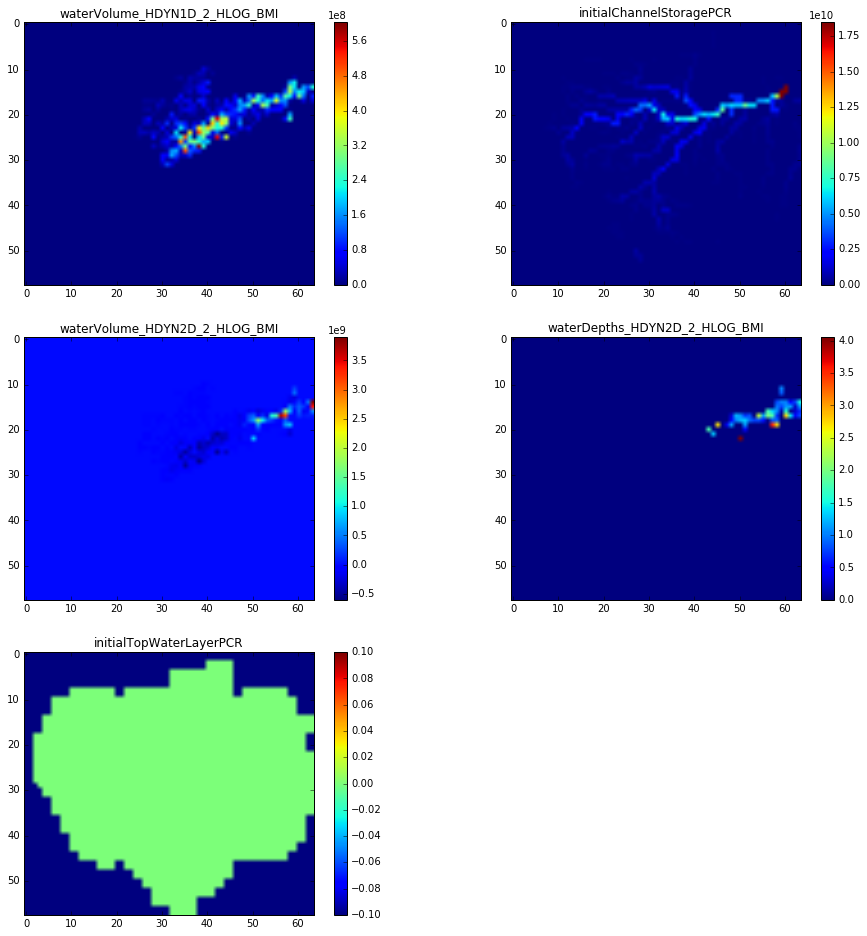

In [14]:
# -------------------------------------------------------------------------------------------------
# COMPUTING WATER VOLUME AND DEPTH TO BE COUPLED BACK TO PCR
#
# waterVolume_HDYN1D_2_HLOG_BMI		= array of accumulated water volume of all 1D hydrodynamic cells within a hydrologic cell
# waterVolume_HDYN2D_2_HLOG_BMI		= array of accumulated water volume of all 2D hydrodynamic cells within a hydrologic cell
# waterDepths_HDYN2D_2_HLOG_BMI		= array of accumulated water depth of all 2D hydrodynamic cells within a hydrologic cell (waterdepth = Vhdyn/Ainund.hdyn)
# -------------------------------------------------------------------------------------------------

waterVolume_HDYN1D_2_HLOG_BMI, waterVolume_HDYN2D_2_HLOG_BMI, waterDepths_HDYN2D_2_HLOG_BMI  = model_functions.determine_InundationDepth_Hydrodynamics(model_type,
																										hydrodynamicModel,
																										landmask_pcr,
																										missing_value_landmask,
																										inundatedArea_HDYN1D_2_HLOG,
																										inundatedArea_HDYN2D_2_HLOG,
																										couple_HLOG_2_HDYN,
																										coupled_HLOG_indices,
																										couple_HLOG_2_HDYN_2way,
																										coupled_HLOG_indices_2way)
plt.figure(figsize=(16,16))
plt.subplot(321)
plt.title('waterVolume_HDYN1D_2_HLOG_BMI')
plt.imshow(waterVolume_HDYN1D_2_HLOG_BMI)
plt.colorbar()
#plt.savefig(os.path.join(verbose_folder,'waterVolume_HDYN1D_2_HLOG_BMI.png'), dpi=300)
plt.subplot(322)
plt.title('initialChannelStoragePCR')
plt.imshow(hydrologicModel.get_var('channelStorage'))
plt.colorbar()
#plt.savefig(os.path.join(verbose_folder,'initialChannelStoragePCR.png'), dpi=300)
plt.subplot(323)
plt.title('waterVolume_HDYN2D_2_HLOG_BMI')
plt.imshow(waterVolume_HDYN2D_2_HLOG_BMI)
plt.colorbar()
print np.min(waterVolume_HDYN2D_2_HLOG_BMI), np.max(waterVolume_HDYN2D_2_HLOG_BMI)
#plt.savefig(os.path.join(verbose_folder,'waterVolume_HDYN2D_2_HLOG_BMI.png'), dpi=300)
plt.subplot(324)
plt.title('waterDepths_HDYN2D_2_HLOG_BMI')
plt.imshow(waterDepths_HDYN2D_2_HLOG_BMI)
plt.colorbar()
#plt.savefig(os.path.join(verbose_folder,'waterDepths_HDYN2D_2_HLOG_BMI.png'), dpi=300)
plt.subplot(325)
plt.title('initialTopWaterLayerPCR')
plt.imshow(hydrologicModel.get_var('topWaterLayer'), vmin=0.000)
plt.colorbar()
#plt.savefig(os.path.join(verbose_folder,'initialTopWaterLayer.png'), dpi=300)
plt.savefig(os.path.join(verbose_folder,'conditionsPCRbefore1stUpdate.png'), dpi=300)

In [15]:
print len(np.where(waterVolume_HDYN2D_2_HLOG_BMI < 0.)[0])
print np.min(waterVolume_HDYN2D_2_HLOG_BMI)

295
-603472394.802


In [16]:
print np.min(waterDepths_HDYN2D_2_HLOG_BMI)
print np.max(waterDepths_HDYN2D_2_HLOG_BMI)

0.0
4.05598413266


0.0
0.0


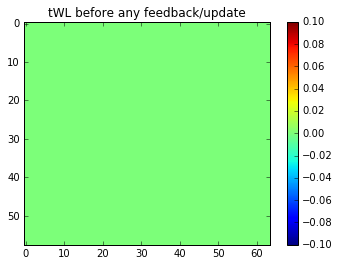

In [17]:
tWL = np.copy(hydrologicModel.get_var('topWaterLayer'))
tWL[tWL<0.] = 0

plt.figure()
plt.title('tWL before any feedback/update')
plt.imshow(tWL, vmin=0.0)
plt.colorbar()

print np.min(tWL)
print np.max(tWL)

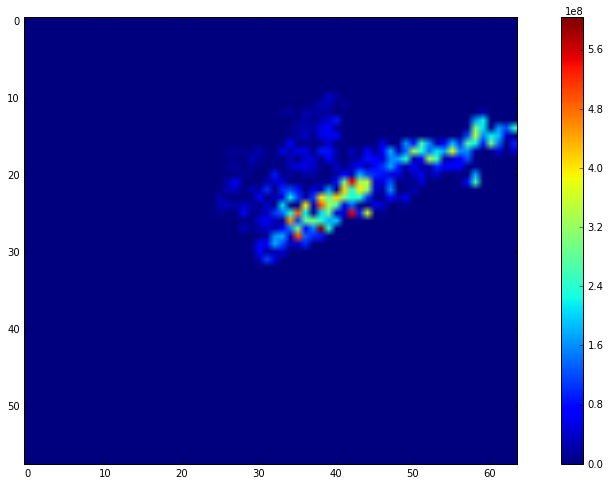

In [18]:
# -------------------------------------------------------------------------------------------------
# UPDATING CHANNELSTORAGE AND TURNING OFF WATERBODYSTORAGE
#
# for 1D HDYN <-> HLOG
# this is required to avoid the entire water volume in channels and waterbodies to empty at once into DFM/LFP
# also, channel storage in HLOG will be updated based on HDYN after first update
# -------------------------------------------------------------------------------------------------

model_functions.updateStorage(hydrologicModel, landmask_pcr, missing_value_pcr, missing_value_landmask, coupled_HLOG_indices, couple_HLOG_2_HDYN, waterVolume_HDYN1D_2_HLOG_BMI)

plt.figure(figsize=(16,8))
plt.imshow(hydrologicModel.get_var('channelStorage'))
plt.colorbar()
plt.savefig(os.path.join(verbose_folder,'updatedChannelStoragePCR.png'), dpi=300)

In [19]:
model_functions.updateHydrologicVariables(hydrologicModel,
                                          waterDepths_HDYN2D_2_HLOG_BMI,
                                          inundatedFraction_HDYN2D_2_HLOG_BMI)

# testWD = hydrologicModel.get_var(('grassland','floodplainWaterLayer'))

In [21]:
# n = 1
# for i in xrange(n):
#     hydrologicModel.update(1)

2018-02-12 12:39:49,237 pcrglobwb_203_30min_2way.pcrglobwb INFO reading forcings for time 1984-01-01
2018-02-12 12:39:49,521 pcrglobwb_203_30min_2way.pcrglobwb INFO updating model to time 1984-01-01
2018-02-12 12:39:49,617 pcrglobwb_203_30min_2way.landSurface INFO WARNING! Domestic water demand is not included.
2018-02-12 12:39:49,618 pcrglobwb_203_30min_2way.landSurface INFO WARNING! Industry water demand is not included.


max tWL before merge:  0.0
max fWL before merge:  4.05598
max tWL+fWL after merge:  4.05598
max tWL before merge:  0.0
max fWL before merge:  4.05598
max tWL+fWL after merge:  4.05598


2018-02-12 12:39:50,619 pcrglobwb_203_30min_2way.waterBodies INFO WARNING!! Using only natural water bodies identified in the year 1900. All reservoirs in 1900 are assumed as lakes.


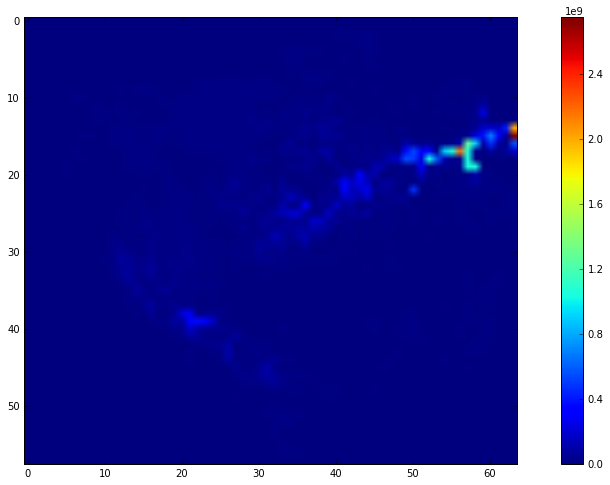

In [22]:
# plt.figure(figsize=(16,8))
# plt.imshow(hydrologicModel.get_var('channelStorage'))
# plt.colorbar()
# plt.savefig(os.path.join(verbose_folder,'updatedChannelStoragePCR_'+str(n)+'tsteps.png'), dpi=300)

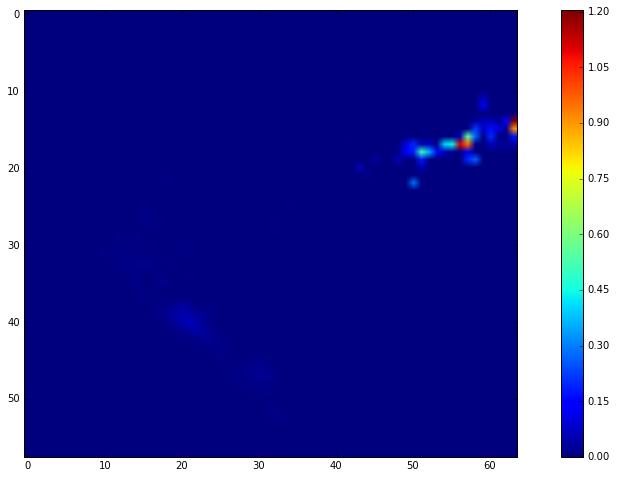

In [23]:
# r = hydrologicModel.get_var('landSurfaceRunoff')
# r[r<0.] = 0

# plt.figure(figsize=(16,8))
# plt.imshow(r, vmin=0)
# plt.colorbar()

# plt.savefig(os.path.join(verbose_folder,'updatedLandSurfaceRunoff_'+str(n)+'tsteps.png'), dpi=300)

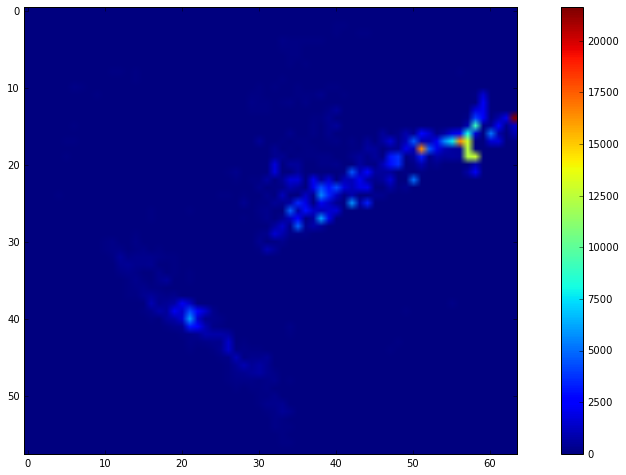

In [24]:
# Q = hydrologicModel.get_var('discharge')
# Q[Q<0.] = 0

# plt.figure(figsize=(16,8))
# plt.imshow(Q, vmin=0)
# plt.colorbar()

# plt.savefig(os.path.join(verbose_folder,'updatedDischarge_'+str(n)+'tsteps.png'), dpi=300)

1359
0.0 -4.05598413266
55
2.354052131e-08 -1.34512748717e-08


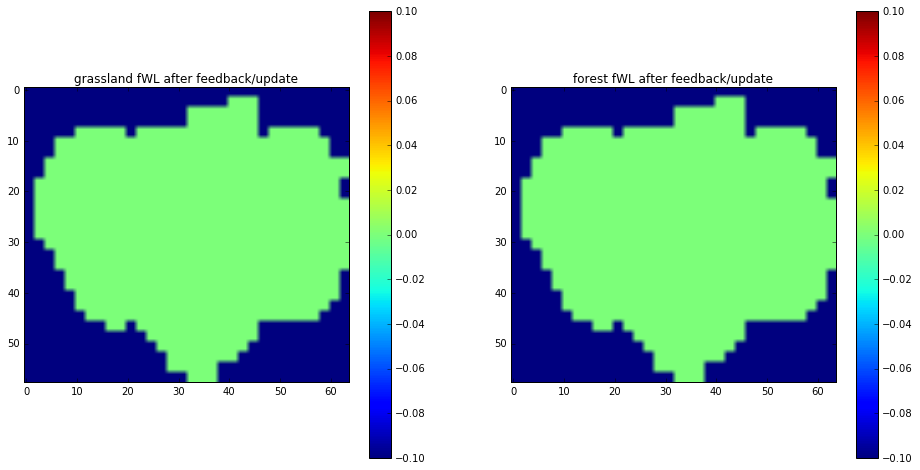

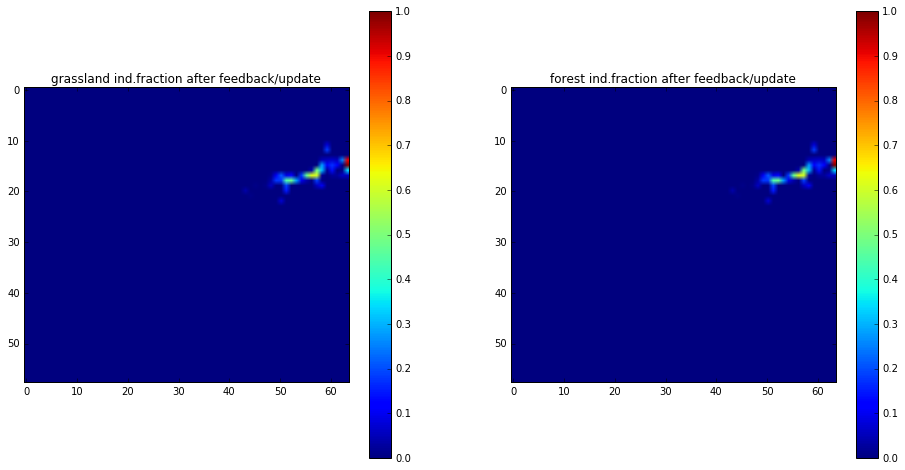

In [25]:
# plt.figure(figsize=(16,8))
# plt.subplot(121)
# plt.title('grassland fWL after feedback/update')
# plt.imshow(hydrologicModel.get_var(('grassland','floodplainWaterLayer')), vmin=0)
# plt.colorbar()
# plt.subplot(122)
# plt.title('forest fWL after feedback/update')
# plt.imshow(hydrologicModel.get_var(('forest','floodplainWaterLayer')), vmin=0)
# plt.colorbar()

# bla = np.copy(hydrologicModel.get_var(('grassland','floodplainWaterLayer')))
# print len(np.where(bla != waterDepths_HDYN2D_2_HLOG_BMI)[0])
# bla[bla==-999.]=0
# diff = bla - waterDepths_HDYN2D_2_HLOG_BMI
# print np.max(diff), np.min(diff)

# plt.figure(figsize=(16,8))
# plt.subplot(121)
# plt.title('grassland ind.fraction after feedback/update')
# plt.imshow(hydrologicModel.get_var(('grassland','inundatedFraction')), vmin=0, vmax=1)
# plt.colorbar()
# plt.subplot(122)
# plt.title('forest ind.fraction after feedback/update')
# plt.imshow(hydrologicModel.get_var(('forest','inundatedFraction')), vmin=0, vmax=1)
# plt.colorbar()

# bla = np.copy(hydrologicModel.get_var(('grassland','inundatedFraction')))
# print len(np.where(bla != inundatedFraction_HDYN2D_2_HLOG_BMI)[0])
# diff = bla - inundatedFraction_HDYN2D_2_HLOG_BMI
# print np.max(diff), np.min(diff)


In [26]:
# n = n+4
# for i in xrange(n):
#     hydrologicModel.update(1)

2018-02-12 12:39:56,967 pcrglobwb_203_30min_2way.pcrglobwb INFO reading forcings for time 1984-01-02
2018-02-12 12:39:57,254 pcrglobwb_203_30min_2way.pcrglobwb INFO updating model to time 1984-01-02


max tWL before merge:  0.0
max fWL before merge:  0.0
max tWL+fWL after merge:  0.0
max tWL before merge:  0.0
max fWL before merge:  0.0
max tWL+fWL after merge:  0.0


2018-02-12 12:39:58,211 pcrglobwb_203_30min_2way.pcrglobwb INFO reading forcings for time 1984-01-03
2018-02-12 12:39:58,475 pcrglobwb_203_30min_2way.pcrglobwb INFO updating model to time 1984-01-03


max tWL before merge:  0.0
max fWL before merge:  0.0
max tWL+fWL after merge:  0.0
max tWL before merge:  0.0
max fWL before merge:  0.0
max tWL+fWL after merge:  0.0


2018-02-12 12:39:59,427 pcrglobwb_203_30min_2way.pcrglobwb INFO reading forcings for time 1984-01-04
2018-02-12 12:39:59,682 pcrglobwb_203_30min_2way.pcrglobwb INFO updating model to time 1984-01-04


max tWL before merge:  0.0
max fWL before merge:  0.0
max tWL+fWL after merge:  0.0
max tWL before merge:  0.0


2018-02-12 12:40:00,630 pcrglobwb_203_30min_2way.pcrglobwb INFO reading forcings for time 1984-01-05
2018-02-12 12:40:00,892 pcrglobwb_203_30min_2way.pcrglobwb INFO updating model to time 1984-01-05


max fWL before merge:  0.0
max tWL+fWL after merge:  0.0
max tWL before merge:  0.0
max fWL before merge:  0.0
max tWL+fWL after merge:  0.0
max tWL before merge:  0.0
max fWL before merge:  0.0
max tWL+fWL after merge:  0.0


2018-02-12 12:40:01,854 pcrglobwb_203_30min_2way.pcrglobwb INFO reading forcings for time 1984-01-06
2018-02-12 12:40:02,113 pcrglobwb_203_30min_2way.pcrglobwb INFO updating model to time 1984-01-06


max tWL before merge:  0.0
max fWL before merge:  0.0
max tWL+fWL after merge:  0.0
max tWL before merge:  0.0
max fWL before merge:  0.0
max tWL+fWL after merge:  0.0


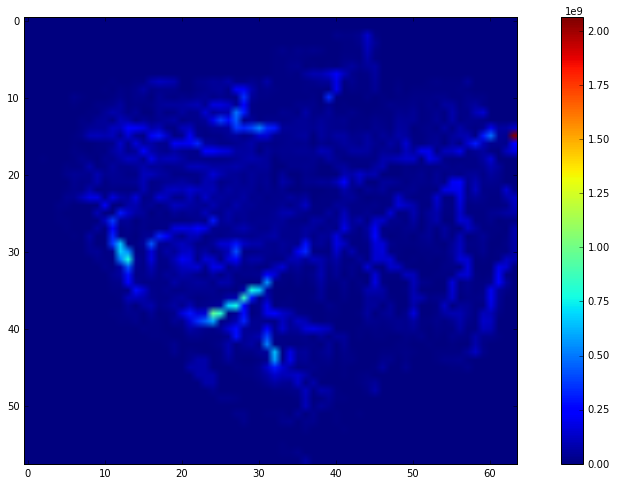

In [27]:
# plt.figure(figsize=(16,8))
# plt.imshow(hydrologicModel.get_var('channelStorage'))
# plt.colorbar()
# plt.savefig(os.path.join(verbose_folder,'updatedChannelStoragePCR_'+str(n)+'tsteps.png'), dpi=300)

In [28]:
waterVolume_HDYN2D_2_HLOG_BMI = np.zeros_like(waterVolume_HDYN2D_2_HLOG_BMI)
delta_volume_PCR, delta_volume_PCR_1way = model_functions.calculateDeltaVolumes(hydrologicModel,
                                                                                missing_value_pcr, 
                                                                                secPerDay, 
                                                                                coupled_HLOG_indices, 
                                                                                cellarea_data_pcr, 
                                                                                waterVolume_HDYN2D_2_HLOG_BMI)

2018-02-12 12:40:04,969 pcrglobwb_203_30min_2way.pcrglobwb INFO reading forcings for time 1984-01-07
2018-02-12 12:40:05,229 pcrglobwb_203_30min_2way.pcrglobwb INFO updating model to time 1984-01-07


max tWL before merge:  0.0
max fWL before merge:  0.0
max tWL+fWL after merge:  0.0
max tWL before merge:  0.0
max fWL before merge:  0.0
max tWL+fWL after merge:  0.0

delta volume of all PCR cells before feedback from DFM: 1.33E+11
feedback volume from FM: 0.00E+00 
delta volume of all PCR cells after feedback from FM: 1.33E+11
reduction by  -0.0 %
delta volume for PCR cells coupled to hydrodynamic channels only 9.25E+09


In [29]:
delta_volume_PCR.shape

(58, 64)

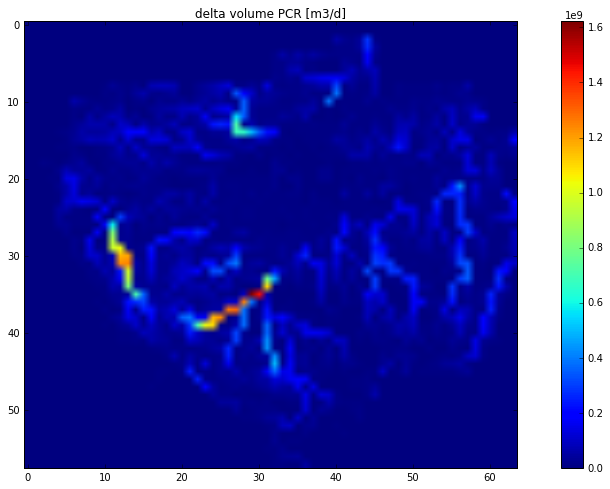

In [30]:
plt.figure(figsize=(16,8))
plt.title('delta volume PCR [m3/d]')
plt.imshow(delta_volume_PCR)
plt.colorbar()

In [31]:
delta_water_DFM_1way, verbose_volume_DFM_1way = model_functions.calculateDeltaWater(hydrodynamicModel, 
                                                                                    couple_HDYN_2_HLOG, 
                                                                                    couple_HLOG_2_HDYN, 
                                                                                    delta_volume_PCR_1way, 
                                                                                    cellAreaSpherical_1D, 
                                                                                    fraction_timestep, 
                                                                                    model_type, 
                                                                                    use_Fluxes)

In [ ]:
print hydrodynamicModel.get_start_time()
print hydrodynamicModel.get_current_time()

model_functions.updateModel(hydrodynamicModel, 
                            delta_water_DFM_1way, 
                            update_step, 
                            separator_1D, 
                            use_Fluxes, 
                            use_RFS, 
                            model_type, 
                            verbose)

print hydrodynamicModel.get_current_time()

0.0
0.0
86400.0


In [ ]:
while hydrologicModel.get_time_step() < nr_model_timesteps:
    
    inundatedArea_HDYN1D_2_HLOG, inundatedArea_HDYN2D_2_HLOG, inundatedArea_HDYN2D_2_HLOG_BMI, \
            inundatedFraction_HDYN2D_2_HLOG, inundatedFraction_HDYN2D_2_HLOG_BMI = model_functions.determine_InundationArea_Hydrodynamics(model_type,
                                                                                                                                        hydrodynamicModel,
                                                                                                                                        couple_HLOG_2_HDYN,
                                                                                                                                        coupled_HLOG_indices,
                                                                                                                                        couple_HLOG_2_HDYN_2way,
                                                                                                                                        coupled_HLOG_indices_2way,
                                                                                                                                        threshold_inundated_depth,
                                                                                                                                        cellAreaSpherical_1D,
                                                                                                                                        cellAreaSpherical_2D,
                                                                                                                                        cellarea_data_pcr,
                                                                                                                                        landmask_pcr,
                                                                                                                                        missing_value_landmask)
    # plt.figure(figsize=(16,8))
    # plt.subplot(121)
    # plt.title('inundatedArea [m2]')
    # plt.imshow(inundatedArea_HDYN2D_2_HLOG_BMI)
    # plt.colorbar()
    # #plt.savefig(os.path.join(verbose_folder,'inundatedArea_HDYN2D_2_HLOG_BMI.png'), dpi=300)
    # plt.subplot(122)
    # plt.title('inundatedFraction [m/m/]')
    # plt.imshow(inundatedFraction_HDYN2D_2_HLOG_BMI, vmin=0, vmax=1)
    # plt.colorbar()
    
    waterVolume_HDYN1D_2_HLOG_BMI, waterVolume_HDYN2D_2_HLOG_BMI, waterDepths_HDYN2D_2_HLOG_BMI  = model_functions.determine_InundationDepth_Hydrodynamics(model_type,
                                                                                                            hydrodynamicModel,
                                                                                                            landmask_pcr,
                                                                                                            missing_value_landmask,
                                                                                                            inundatedArea_HDYN1D_2_HLOG,
                                                                                                            inundatedArea_HDYN2D_2_HLOG,
                                                                                                            couple_HLOG_2_HDYN,
                                                                                                            coupled_HLOG_indices,
                                                                                                            couple_HLOG_2_HDYN_2way,
                                                                                                            coupled_HLOG_indices_2way)

    # plt.figure(figsize=(16,16))
    # plt.subplot(321)
    # plt.title('waterVolume_HDYN1D_2_HLOG_BMI')
    # plt.imshow(waterVolume_HDYN1D_2_HLOG_BMI)
    # plt.colorbar()

    # plt.subplot(322)
    # plt.title('initialChannelStoragePCR')
    # plt.imshow(hydrologicModel.get_var('channelStorage'))
    # plt.colorbar()

    # plt.subplot(323)
    # plt.title('waterVolume_HDYN2D_2_HLOG_BMI')
    # plt.imshow(waterVolume_HDYN2D_2_HLOG_BMI)
    # plt.colorbar()
    # print np.min(waterVolume_HDYN2D_2_HLOG_BMI), np.max(waterVolume_HDYN2D_2_HLOG_BMI)

    # plt.subplot(324)
    # plt.title('waterDepths_HDYN2D_2_HLOG_BMI')
    # plt.imshow(waterDepths_HDYN2D_2_HLOG_BMI)
    # plt.colorbar()

    # plt.subplot(325)
    # plt.title('initialTopWaterLayerPCR')
    # plt.imshow(hydrologicModel.get_var('topWaterLayer'), vmin=0.000)
    # plt.colorbar()
    
    model_functions.updateStorage(hydrologicModel, 
                                  landmask_pcr, 
                                  missing_value_pcr, 
                                  missing_value_landmask, 
                                  coupled_HLOG_indices, 
                                  couple_HLOG_2_HDYN, 
                                  waterVolume_HDYN1D_2_HLOG_BMI)
    
    model_functions.updateHydrologicVariables(hydrologicModel,
                                              waterDepths_HDYN2D_2_HLOG_BMI,
                                              inundatedFraction_HDYN2D_2_HLOG_BMI)
    
    # here the accounting of differences in water volume and water level has to be (is) implemented
    delta_volume_PCR, delta_volume_PCR_1way = model_functions.calculateDeltaVolumes(hydrologicModel,
                                                                                    missing_value_pcr, 
                                                                                    secPerDay, 
                                                                                    coupled_HLOG_indices, 
                                                                                    cellarea_data_pcr, 
                                                                                    waterVolume_HDYN2D_2_HLOG_BMI)
    
    delta_water_DFM_1way, verbose_volume_DFM_1way = model_functions.calculateDeltaWater(hydrodynamicModel, 
                                                                                        couple_HDYN_2_HLOG, 
                                                                                        couple_HLOG_2_HDYN, 
                                                                                        delta_volume_PCR_1way, 
                                                                                        cellAreaSpherical_1D, 
                                                                                        fraction_timestep, 
                                                                                        model_type, 
                                                                                        use_Fluxes)

    model_functions.updateModel(hydrodynamicModel, 
                            delta_water_DFM_1way, 
                            update_step, 
                            separator_1D, 
                            use_Fluxes, 
                            use_RFS, 
                            model_type, 
                            verbose)

    print hydrodynamicModel.get_current_time()


2018-02-12 12:40:11,845 pcrglobwb_203_30min_2way.pcrglobwb INFO reading forcings for time 1984-01-08
2018-02-12 12:40:12,163 pcrglobwb_203_30min_2way.pcrglobwb INFO updating model to time 1984-01-08


max tWL before merge:  0.0
max fWL before merge:  4.0684
max tWL+fWL after merge:  4.0684
max tWL before merge:  0.0
max fWL before merge:  4.0684
max tWL+fWL after merge:  4.0684

delta volume of all PCR cells before feedback from DFM: 7.56E+10
feedback volume from FM: 6.83E+09 
delta volume of all PCR cells after feedback from FM: 6.88E+10
reduction by  9.03 %
delta volume for PCR cells coupled to hydrodynamic channels only 6.12E+10


2018-02-12 12:40:16,773 pcrglobwb_203_30min_2way.pcrglobwb INFO reading forcings for time 1984-01-09


172800.0


2018-02-12 12:40:17,095 pcrglobwb_203_30min_2way.pcrglobwb INFO updating model to time 1984-01-09


max tWL before merge:  0.0
max fWL before merge:  4.17088
max tWL+fWL after merge:  4.17088
max tWL before merge:  0.0
max fWL before merge:  4.17088
max tWL+fWL after merge:  4.17088

delta volume of all PCR cells before feedback from DFM: 7.83E+10
feedback volume from FM: 7.43E+09 
delta volume of all PCR cells after feedback from FM: 7.08E+10
reduction by  9.5 %
delta volume for PCR cells coupled to hydrodynamic channels only 6.33E+10


2018-02-12 12:40:22,489 pcrglobwb_203_30min_2way.pcrglobwb INFO reading forcings for time 1984-01-10


259200.0


2018-02-12 12:40:22,803 pcrglobwb_203_30min_2way.pcrglobwb INFO updating model to time 1984-01-10


max tWL before merge:  0.0
max fWL before merge:  4.42879
max tWL+fWL after merge:  4.42879
max tWL before merge:  0.0
max fWL before merge:  4.42879
max tWL+fWL after merge:  4.42879

delta volume of all PCR cells before feedback from DFM: 8.80E+10
feedback volume from FM: 1.06E+10 
delta volume of all PCR cells after feedback from FM: 7.74E+10
reduction by  12.01 %
delta volume for PCR cells coupled to hydrodynamic channels only 6.72E+10


2018-02-12 12:40:27,818 pcrglobwb_203_30min_2way.pcrglobwb INFO reading forcings for time 1984-01-11


345600.0


2018-02-12 12:40:28,152 pcrglobwb_203_30min_2way.pcrglobwb INFO updating model to time 1984-01-11


max tWL before merge:  0.0
max fWL before merge:  4.52592
max tWL+fWL after merge:  4.52592
max tWL before merge:  0.0
max fWL before merge:  4.52592
max tWL+fWL after merge:  4.52592

delta volume of all PCR cells before feedback from DFM: 1.06E+11
feedback volume from FM: 1.74E+10 
delta volume of all PCR cells after feedback from FM: 8.82E+10
reduction by  16.47 %
delta volume for PCR cells coupled to hydrodynamic channels only 7.84E+10


2018-02-12 12:40:33,304 pcrglobwb_203_30min_2way.pcrglobwb INFO reading forcings for time 1984-01-12


432000.0


2018-02-12 12:40:33,623 pcrglobwb_203_30min_2way.pcrglobwb INFO updating model to time 1984-01-12


max tWL before merge:  0.0
max fWL before merge:  4.60891
max tWL+fWL after merge:  4.60891
max tWL before merge:  0.0
max fWL before merge:  4.60891
max tWL+fWL after merge:  4.60891

delta volume of all PCR cells before feedback from DFM: 1.34E+11
feedback volume from FM: 2.89E+10 
delta volume of all PCR cells after feedback from FM: 1.05E+11
reduction by  21.52 %
delta volume for PCR cells coupled to hydrodynamic channels only 9.60E+10


2018-02-12 12:40:39,399 pcrglobwb_203_30min_2way.pcrglobwb INFO reading forcings for time 1984-01-13


518400.0


2018-02-12 12:40:39,730 pcrglobwb_203_30min_2way.pcrglobwb INFO updating model to time 1984-01-13


max tWL before merge:  0.0
max fWL before merge:  4.69509
max tWL+fWL after merge:  4.69509
max tWL before merge:  0.0
max fWL before merge:  4.69509
max tWL+fWL after merge:  4.69509

delta volume of all PCR cells before feedback from DFM: 1.84E+11
feedback volume from FM: 4.71E+10 
delta volume of all PCR cells after feedback from FM: 1.37E+11
reduction by  25.61 %
delta volume for PCR cells coupled to hydrodynamic channels only 1.27E+11


2018-02-12 12:40:46,852 pcrglobwb_203_30min_2way.pcrglobwb INFO reading forcings for time 1984-01-14


604800.0


2018-02-12 12:40:47,194 pcrglobwb_203_30min_2way.pcrglobwb INFO updating model to time 1984-01-14


max tWL before merge:  0.0
max fWL before merge:  4.92754
max tWL+fWL after merge:  4.92754
max tWL before merge:  0.0
max fWL before merge:  4.92754
max tWL+fWL after merge:  4.92754

delta volume of all PCR cells before feedback from DFM: 2.59E+11
feedback volume from FM: 7.64E+10 
delta volume of all PCR cells after feedback from FM: 1.83E+11
reduction by  29.47 %
delta volume for PCR cells coupled to hydrodynamic channels only 1.72E+11


2018-02-12 12:40:54,974 pcrglobwb_203_30min_2way.pcrglobwb INFO reading forcings for time 1984-01-15


691200.0


2018-02-12 12:40:55,270 pcrglobwb_203_30min_2way.pcrglobwb INFO updating model to time 1984-01-15


max tWL before merge:  0.0
max fWL before merge:  5.42753
max tWL+fWL after merge:  5.42753
max tWL before merge:  0.0
max fWL before merge:  5.42753
max tWL+fWL after merge:  5.42753

delta volume of all PCR cells before feedback from DFM: 3.74E+11
feedback volume from FM: 1.24E+11 
delta volume of all PCR cells after feedback from FM: 2.50E+11
reduction by  33.1 %
delta volume for PCR cells coupled to hydrodynamic channels only 2.39E+11


2018-02-12 12:41:04,079 pcrglobwb_203_30min_2way.pcrglobwb INFO reading forcings for time 1984-01-16


777600.0


2018-02-12 12:41:04,419 pcrglobwb_203_30min_2way.pcrglobwb INFO updating model to time 1984-01-16


max tWL before merge:  0.0
max fWL before merge:  6.47853
max tWL+fWL after merge:  6.47853
max tWL before merge:  0.0
max fWL before merge:  6.47853
max tWL+fWL after merge:  6.47853

delta volume of all PCR cells before feedback from DFM: 5.52E+11
feedback volume from FM: 2.02E+11 
delta volume of all PCR cells after feedback from FM: 3.50E+11
reduction by  36.55 %
delta volume for PCR cells coupled to hydrodynamic channels only 3.40E+11


2018-02-12 12:41:11,765 pcrglobwb_203_30min_2way.pcrglobwb INFO reading forcings for time 1984-01-17


864000.0


2018-02-12 12:41:12,074 pcrglobwb_203_30min_2way.pcrglobwb INFO updating model to time 1984-01-17


max tWL before merge:  0.0
max fWL before merge:  11.5768
max tWL+fWL after merge:  11.5768
max tWL before merge:  0.0
max fWL before merge:  11.5768
max tWL+fWL after merge:  11.5768

delta volume of all PCR cells before feedback from DFM: 8.38E+11
feedback volume from FM: 3.31E+11 
delta volume of all PCR cells after feedback from FM: 5.08E+11
reduction by  39.45 %
delta volume for PCR cells coupled to hydrodynamic channels only 4.97E+11


2018-02-12 12:41:20,978 pcrglobwb_203_30min_2way.pcrglobwb INFO reading forcings for time 1984-01-18


950400.0


2018-02-12 12:41:21,290 pcrglobwb_203_30min_2way.pcrglobwb INFO updating model to time 1984-01-18


max tWL before merge:  0.0
max fWL before merge:  13.4323
max tWL+fWL after merge:  13.4323
max tWL before merge:  0.0
max fWL before merge:  13.4323
max tWL+fWL after merge:  13.4323

delta volume of all PCR cells before feedback from DFM: 1.30E+12
feedback volume from FM: 5.49E+11 
delta volume of all PCR cells after feedback from FM: 7.49E+11
reduction by  42.29 %
delta volume for PCR cells coupled to hydrodynamic channels only 7.37E+11


2018-02-12 12:41:30,756 pcrglobwb_203_30min_2way.pcrglobwb INFO reading forcings for time 1984-01-19


1036800.0


2018-02-12 12:41:31,068 pcrglobwb_203_30min_2way.pcrglobwb INFO updating model to time 1984-01-19


max tWL before merge:  0.0
max fWL before merge:  13.5415
max tWL+fWL after merge:  13.5415
max tWL before merge:  0.0
max fWL before merge:  13.5415
max tWL+fWL after merge:  13.5415

delta volume of all PCR cells before feedback from DFM: 2.06E+12
feedback volume from FM: 9.22E+11 
delta volume of all PCR cells after feedback from FM: 1.14E+12
reduction by  44.79 %
delta volume for PCR cells coupled to hydrodynamic channels only 1.12E+12


2018-02-12 12:41:43,047 pcrglobwb_203_30min_2way.pcrglobwb INFO reading forcings for time 1984-01-20


1123200.0


2018-02-12 12:41:43,383 pcrglobwb_203_30min_2way.pcrglobwb INFO updating model to time 1984-01-20


max tWL before merge:  0.0
max fWL before merge:  13.7174
max tWL+fWL after merge:  13.7174
max tWL before merge:  0.0
max fWL before merge:  13.7174
max tWL+fWL after merge:  13.7174

delta volume of all PCR cells before feedback from DFM: 3.32E+12
feedback volume from FM: 1.57E+12 
delta volume of all PCR cells after feedback from FM: 1.75E+12
reduction by  47.24 %
delta volume for PCR cells coupled to hydrodynamic channels only 1.74E+12


2018-02-12 12:41:59,041 pcrglobwb_203_30min_2way.pcrglobwb INFO reading forcings for time 1984-01-21


1209600.0


2018-02-12 12:41:59,405 pcrglobwb_203_30min_2way.pcrglobwb INFO updating model to time 1984-01-21


max tWL before merge:  0.0
max fWL before merge:  17.3468
max tWL+fWL after merge:  17.3468
max tWL before merge:  0.0
max fWL before merge:  17.3468
max tWL+fWL after merge:  17.3468

delta volume of all PCR cells before feedback from DFM: 5.48E+12
feedback volume from FM: 2.69E+12 
delta volume of all PCR cells after feedback from FM: 2.80E+12
reduction by  49.01 %
delta volume for PCR cells coupled to hydrodynamic channels only 2.78E+12


2018-02-12 12:42:14,971 pcrglobwb_203_30min_2way.pcrglobwb INFO reading forcings for time 1984-01-22


1296000.0


2018-02-12 12:42:15,279 pcrglobwb_203_30min_2way.pcrglobwb INFO updating model to time 1984-01-22


max tWL before merge:  0.0
max fWL before merge:  26.4167
max tWL+fWL after merge:  26.4167
max tWL before merge:  0.0
max fWL before merge:  26.4167
max tWL+fWL after merge:  26.4167

delta volume of all PCR cells before feedback from DFM: 9.24E+12
feedback volume from FM: 4.57E+12 
delta volume of all PCR cells after feedback from FM: 4.67E+12
reduction by  49.45 %
delta volume for PCR cells coupled to hydrodynamic channels only 4.64E+12


2018-02-12 12:42:33,101 pcrglobwb_203_30min_2way.pcrglobwb INFO reading forcings for time 1984-01-23


1382400.0


2018-02-12 12:42:33,439 pcrglobwb_203_30min_2way.pcrglobwb INFO updating model to time 1984-01-23


max tWL before merge:  0.0
max fWL before merge:  35.2192
max tWL+fWL after merge:  35.2192
max tWL before merge:  0.0
max fWL before merge:  35.2192
max tWL+fWL after merge:  35.2192

delta volume of all PCR cells before feedback from DFM: 1.68E+13
feedback volume from FM: 7.82E+12 
delta volume of all PCR cells after feedback from FM: 8.96E+12
reduction by  46.61 %
delta volume for PCR cells coupled to hydrodynamic channels only 8.91E+12


2018-02-12 12:43:14,584 pcrglobwb_203_30min_2way.pcrglobwb INFO reading forcings for time 1984-01-24


1468800.0


2018-02-12 12:43:14,909 pcrglobwb_203_30min_2way.pcrglobwb INFO updating model to time 1984-01-24


max tWL before merge:  0.0
max fWL before merge:  50.3524
max tWL+fWL after merge:  50.3524
max tWL before merge:  0.0
max fWL before merge:  50.3524
max tWL+fWL after merge:  50.3524

delta volume of all PCR cells before feedback from DFM: 3.90E+13
feedback volume from FM: 1.42E+13 
delta volume of all PCR cells after feedback from FM: 2.48E+13
reduction by  36.46 %
delta volume for PCR cells coupled to hydrodynamic channels only 2.47E+13
